In [1]:
import pyaudio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython import display
from tensorflow.keras import models

In [3]:
FRAMES_PER_BUFFER = 3200
FORMAT = pyaudio.paInt16
CHANNELS = 1
RATE = 16000
p = pyaudio.PyAudio()

def record_audio():
    stream = p.open(
        format=FORMAT,
        channels=CHANNELS,
        rate=RATE,
        input=True,
        frames_per_buffer=FRAMES_PER_BUFFER
    )

    print("start recording...")

    frames = []
    seconds = 1
    for i in range(0, int(RATE / FRAMES_PER_BUFFER * seconds)):
        data = stream.read(FRAMES_PER_BUFFER)
        frames.append(data)

    print("recording stopped")

    stream.stop_stream()
    stream.close()
    
    return np.frombuffer(b''.join(frames), dtype=np.int16)

In [4]:
model = models.load_model("saved_model")

In [5]:
lables = ['down', 'go','left','no','right', 'stop', 'up',  'yes']

In [6]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [7]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

start recording...
recording stopped


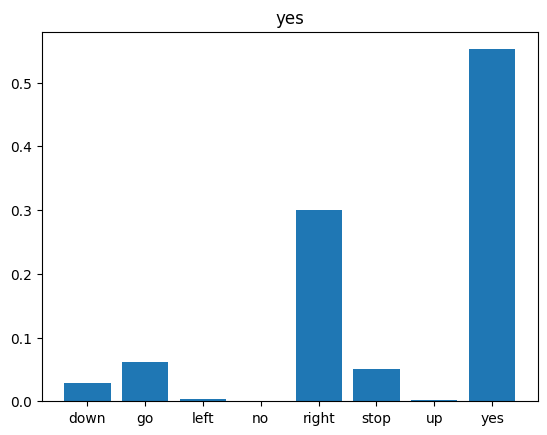

In [11]:
audio = record_audio()
audio = audio / 32768 #normalization tf.audio.decode_wav
audio = tf.convert_to_tensor(audio, dtype=tf.float32)
spectrogram = get_spectrogram(audio)

spectrogram = spectrogram[tf.newaxis,...]
prediction = model(spectrogram)
lable_prediction = np.argmax(prediction, axis=1)
x_labels = [ 'down', 'go','left','no','right', 'stop', 'up',  'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title(x_labels[lable_prediction[0]])
plt.show()

display.display(display.Audio(audio, rate=16000))